In [9]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
with open('gru_outputs_250_000_episodes_1e4_LR_40_tasks/test_sessions_data.pkl', 'rb') as file:
    test_sessions_data = pickle.load(file)

with open('gru_outputs_250_000_episodes_1e4_LR_40_tasks/test_tasks.txt', 'r') as file:
    test_tasks = [list(map(int, line.strip()[1:-1].split(', '))) for line in file.readlines()]

In [11]:
# Create a list to store the dataframes
dataframes = []

# Iterate through each session in test_sessions_data
for session in test_sessions_data:
    # Convert the list of dictionaries (timepoints) to a dataframe
    df = pd.DataFrame(session)
    dataframes.append(df)

In [12]:
dataframes

[     time                                         activation  \
 0       0  [0.40027705, -0.6230227, 0.21858223, 0.0627678...   
 1       1  [0.2291992, 0.40897423, 0.17336263, -0.0326887...   
 2       2  [0.5412635, 0.28069454, 0.15837455, 0.00506404...   
 3       3  [0.44409385, -0.18621093, 0.15330392, 0.048516...   
 4       4  [0.29241693, -0.22895826, 0.12015699, 0.067164...   
 ..    ...                                                ...   
 195   195  [0.50108147, -0.19275558, 0.15753011, -0.98638...   
 196   196  [0.49902487, -0.19281766, 0.13297582, -0.98650...   
 197   197  [0.49836445, -0.19282208, 0.1344662, -0.986613...   
 198   198  [0.49545696, -0.19295426, 0.14802381, -0.98670...   
 199   199  [0.5011358, -0.19305544, 0.15007281, -0.986831...   
 
                                            observation  location  past_action  \
 0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...         8           -1   
 1    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..

In [13]:
import seaborn as sns

# Initialize a dictionary to store the heatmaps for each unit
heatmaps = {}

# Iterate through each unit in the activation
for unit in range(len(dataframes[0]['activation'][0])):
    # Initialize a 5x4 matrix to store the average activations
    avg_activations = np.zeros((5, 4))
    
    # Iterate through each session (dataframe)
    for i, df in enumerate(dataframes):
        # Filter the dataframe by reward labels
        for j, label in enumerate(['A', 'B', 'C', 'D']):
            # Get the activations for the current unit where the reward label is the current label
            activations = df[df['reward_label'] == label]['activation'].apply(lambda x: x[unit])
            # Calculate the average activation and store it in the matrix
            if not activations.empty:
                avg_activations[i, j] = activations.mean()
    
    # # Create a heatmap for the current unit
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(avg_activations, annot=True, xticklabels=['A', 'B', 'C', 'D'], yticklabels=[f'Session {i+1}' for i in range(5)])
    # plt.title(f'Heatmap for Unit {unit}')
    # plt.xlabel('Reward Label')
    # plt.ylabel('Session')
    # plt.show()
    
    # # Store the heatmap in the dictionary
    # heatmaps[unit] = avg_activations

In [14]:
# Initialize a dictionary to store the heatmaps for each unit
location_heatmaps = {}

# Iterate through each unit in the activation
for unit in range(len(dataframes[0]['activation'][0])):
    # Initialize a 5x9 matrix to store the average activations (5 sessions x 9 locations)
    avg_activations = np.zeros((5, 9))
    
    # Iterate through each session (dataframe)
    for i, df in enumerate(dataframes):
        # Filter the dataframe by location
        for j in range(9):
            # Get the activations for the current unit where the location is the current location
            activations = df[df['location'] == j]['activation'].apply(lambda x: x[unit])
            # Calculate the average activation and store it in the matrix
            if not activations.empty:
                avg_activations[i, j] = activations.mean()
    
    # Create a heatmap for the current unit
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(avg_activations, annot=True, xticklabels=[f'Location {j}' for j in range(9)], yticklabels=[f'Session {i+1}' for i in range(5)])
    # plt.title(f'Heatmap for Unit {unit} by Location')
    # plt.xlabel('Location')
    # plt.ylabel('Session')
    # plt.show()
    
    # Store the heatmap in the dictionary
    location_heatmaps[unit] = avg_activations

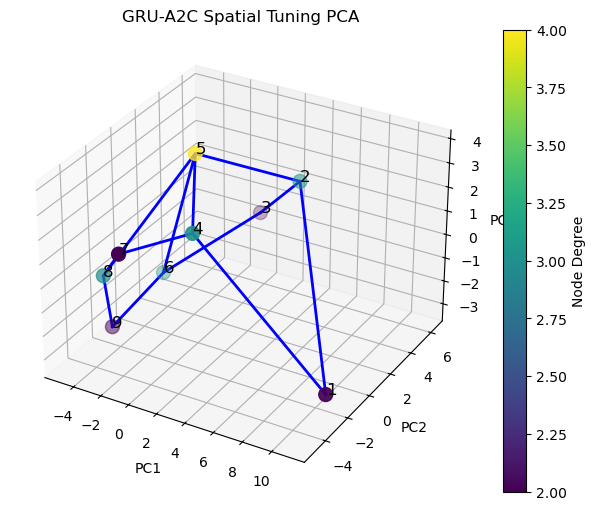

In [28]:
from sklearn.decomposition import PCA

# Step 1: Concatenate the spatial tuning responses for all neurons and sessions.
all_responses = np.concatenate(list(location_heatmaps.values()), axis=0)

# Step 2: For a population representation of each spatial location, we want one 9-dimensional vector per location.
X = all_responses.T  # shape: (9, num_neurons * num_sessions)

# Step 3: Run PCA on the 9 observations (each is a "population vector" for one location)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)  # shape: (9, 3)

# Step 4: Plot the 9 points in 3D and connect them as in a 3x3 maze.
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Use node degrees for coloring (node_degrees and degrees are defined in a later cell)
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=100, c=degrees, cmap='viridis')
plt.colorbar(scatter, ax=ax, label='Node Degree')
for loc_idx, (x, y, z) in enumerate(X_pca):
    ax.text(x, y, z, str(loc_idx+1), fontsize=12)

# Define maze connectivity by rows and columns.
maze_rows = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
maze_cols = [[0, 3, 6], [1, 4, 7], [2, 5, 8]]

# Draw horizontal (row) and vertical (column) connections.
for row in maze_rows:
    ax.plot(X_pca[row, 0], X_pca[row, 1], X_pca[row, 2], color='blue', lw=2)
for col in maze_cols:
    ax.plot(X_pca[col, 0], X_pca[col, 1], X_pca[col, 2], color='blue', lw=2)

ax.set_title("GRU-A2C Spatial Tuning PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


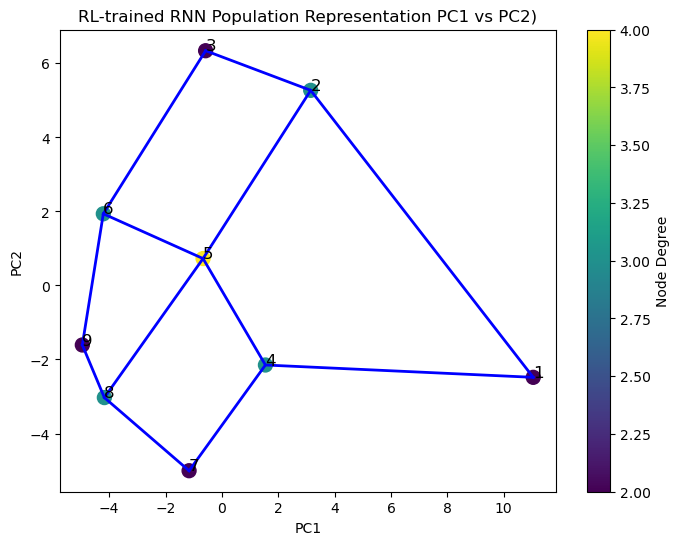

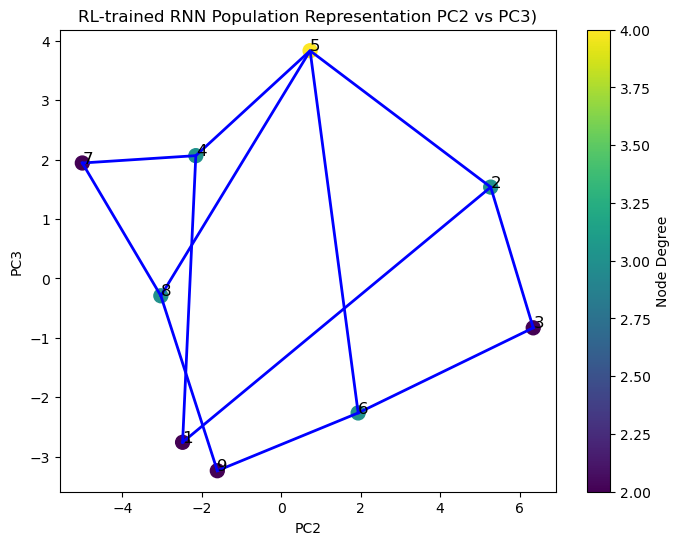

In [ ]:
# Define node degrees for a 3x3 grid
node_degrees = {0: 2, 1: 3, 2: 2,
                3: 3, 4: 4, 5: 3,
                6: 2, 7: 3, 8: 2}
# Create an array of degrees corresponding to the nodes (0-8)
degrees = np.array([node_degrees[i] for i in range(9)])

# -----------------------------------------------
# Plot 1: Projection into PC1 and PC2 with degree-based colors
# -----------------------------------------------
fig1, ax1 = plt.subplots(figsize=(8, 6))
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], s=100, c=degrees, cmap='viridis')
for loc_idx, (x, y, _) in enumerate(X_pca):
    ax1.text(x, y, str(loc_idx+1), fontsize=12)
# Draw horizontal connections (maze rows)
for row in maze_rows:
    ax1.plot(X_pca[row, 0], X_pca[row, 1], color='blue', lw=2)
# Draw vertical connections (maze columns)
for col in maze_cols:
    ax1.plot(X_pca[col, 0], X_pca[col, 1], color='blue', lw=2)
ax1.set_title("RL-trained RNN Population Representation PC1 vs PC2)")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
plt.colorbar(scatter1, ax=ax1, label='Node Degree')
plt.show()

# -----------------------------------------------
# Plot 2: Projection into PC2 and PC3 with degree-based colors
# -----------------------------------------------
fig2, ax2 = plt.subplots(figsize=(8, 6))
scatter2 = ax2.scatter(X_pca[:, 1], X_pca[:, 2], s=100, c=degrees, cmap='viridis')
for loc_idx, (_, y, z) in enumerate(X_pca):
    ax2.text(y, z, str(loc_idx+1), fontsize=12)
# Draw horizontal connections (maze rows) using PC2 and PC3
for row in maze_rows:
    ax2.plot(X_pca[row, 1], X_pca[row, 2], color='blue', lw=2)
# Draw vertical connections (maze columns)
for col in maze_cols:
    ax2.plot(X_pca[col, 1], X_pca[col, 2], color='blue', lw=2)
ax2.set_title("RL-trained RNN Population Representation PC2 vs PC3)")
ax2.set_xlabel("PC2")
ax2.set_ylabel("PC3")
plt.colorbar(scatter2, ax=ax2, label='Node Degree')
plt.show()$


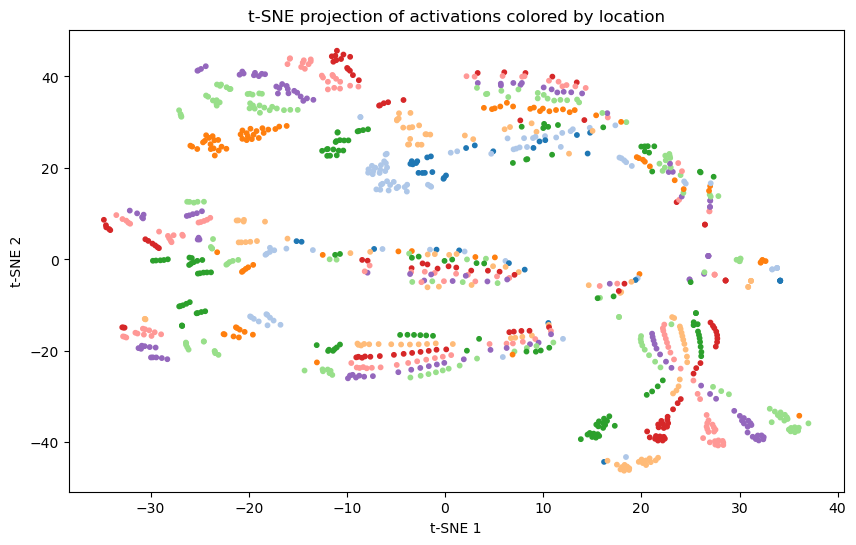

In [29]:
from sklearn.manifold import TSNE

# Combine all sessions into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Extract the activations from the combined dataframe
activations = np.array(combined_df['activation'].tolist())

# Perform t-SNE on the activations
tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(activations)

# Map locations to colors
location_colors = {i: plt.cm.tab20(i) for i in range(9)}
colors = combined_df['location'].map(location_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)
plt.title('t-SNE projection of activations colored by location')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

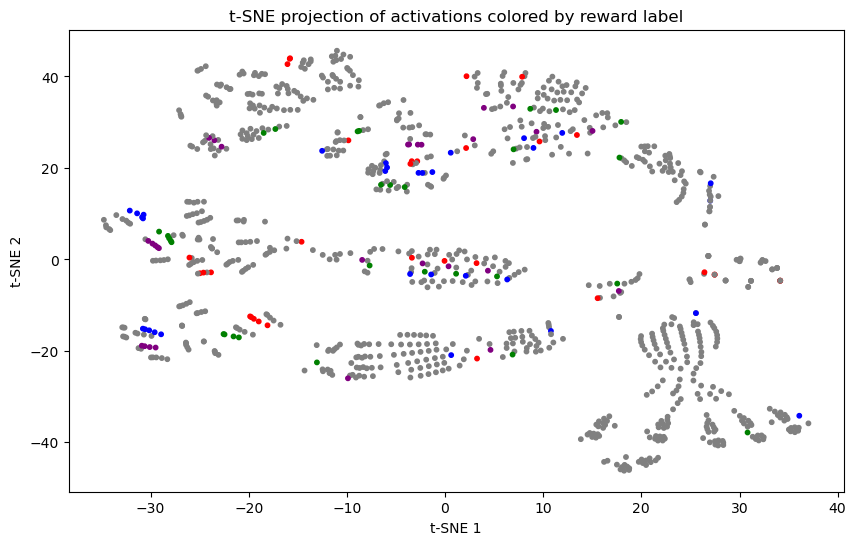

In [30]:
# Map reward labels to colors, grey if None
reward_colors = {'A': 'red', 'B': 'blue', 'C': 'green', 'D': 'purple', None: 'grey'}
colors = combined_df['reward_label'].map(reward_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)
plt.title('t-SNE projection of activations colored by reward label')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


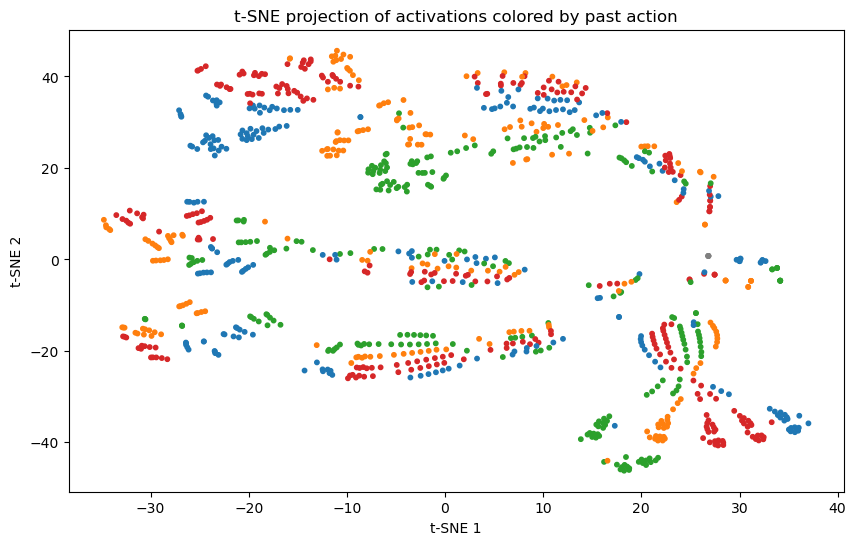

In [31]:
# Map actions to colors
action_colors = {i: plt.cm.tab10(i) for i in range(10)}
colors = combined_df['past_action'].map(action_colors)

# Replace NaN values with a default color (e.g., grey)
colors = colors.fillna('grey')

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)
plt.title('t-SNE projection of activations colored by past action')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


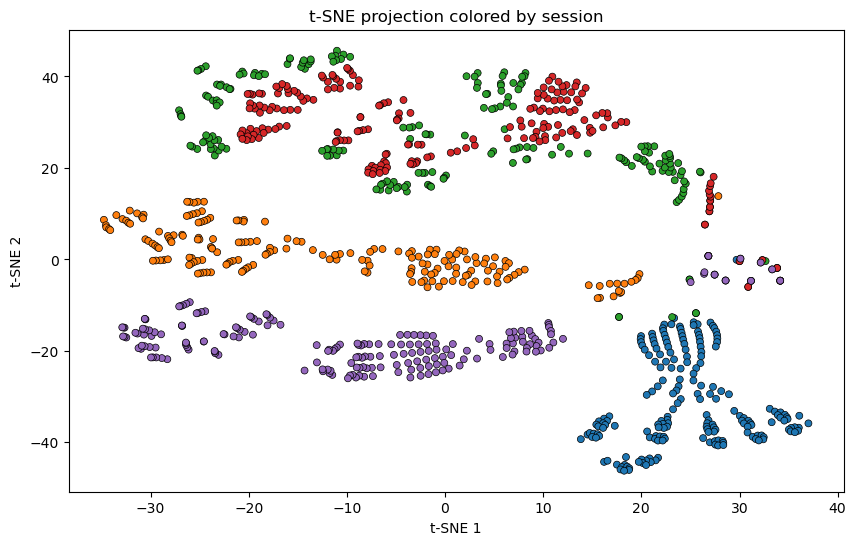

In [41]:
# Create a session label column in combined_df
combined_df['session'] = np.repeat(np.arange(len(dataframes)), [len(df) for df in dataframes])

# Map each session to a unique color using the tab10 colormap.
session_colors = {i: plt.cm.tab10(i) for i in range(len(dataframes))}
colors = combined_df['session'].map(session_colors)

# Plot the t-SNE embedding colored by session
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=25, edgecolors='k', linewidths=0.5)
plt.title('t-SNE projection colored by session')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


/usr/local/fsl/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


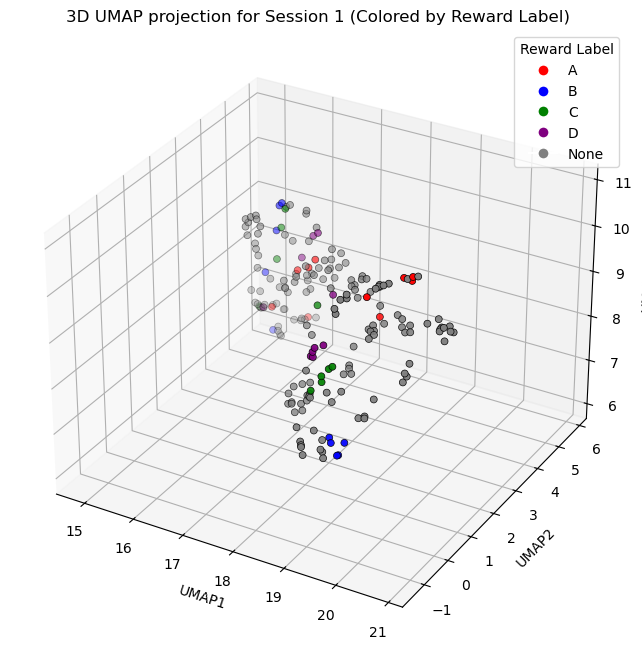

In [45]:
# Filter combined_df for session 1 only
session1_df = combined_df[combined_df['session'] == 1]

# Create a 3D UMAP embedding from the activations in session1_df
activations = np.array(session1_df['activation'].tolist())
umap_3d = umap.UMAP(n_components=3, random_state=42)
embedding_umap = umap_3d.fit_transform(activations)

# Map reward labels to colors using the reward_colors dictionary
colors = session1_df['reward_label'].map(reward_colors)

# Plot the 3D UMAP embedding for session 1 colored by reward label
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding_umap[:, 0], embedding_umap[:, 1], embedding_umap[:, 2],
                     s=25, edgecolors='k', linewidths=0.5, c=colors)
ax.set_title('3D UMAP projection for Session 1 (Colored by Reward Label)')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Create a legend for reward labels using only labels present in session1_df
labels_used = session1_df['reward_label'].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=reward_colors[label],
                      markersize=8, label=str(label)) for label in sorted(labels_used, key=lambda x: (x is None, x))]
ax.legend(handles=handles, title='Reward Label')

plt.show()


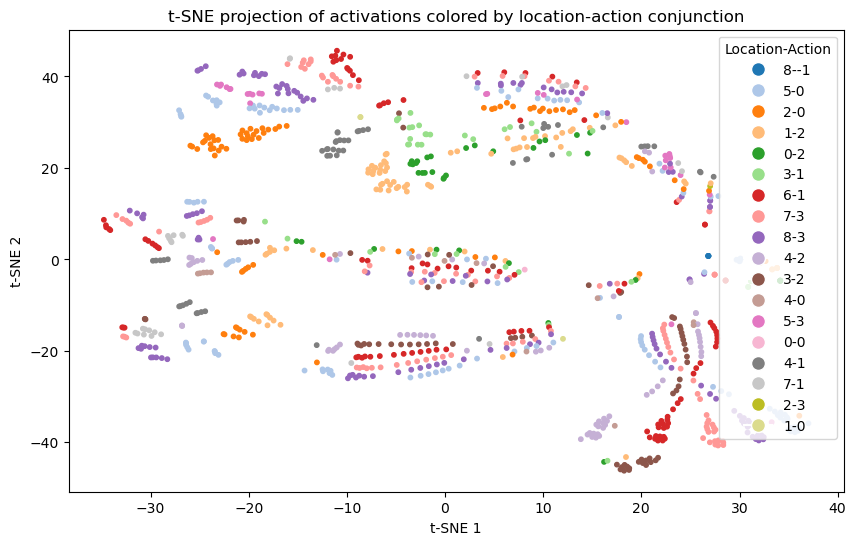

In [32]:
# Create a combined column for location and past action
combined_df['location_action'] = combined_df['location'].astype(str) + '-' + combined_df['past_action'].astype(str)

# Generate a unique color for each location-action combination
unique_combinations = combined_df['location_action'].unique()
combination_colors = {comb: plt.cm.tab20(i % 20) for i, comb in enumerate(unique_combinations)}

# Map the combined column to colors
colors = combined_df['location_action'].map(combination_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=combination_colors[comb], markersize=10) for comb in unique_combinations]
plt.legend(handles, unique_combinations, title='Location-Action')

plt.title('t-SNE projection of activations colored by location-action conjunction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


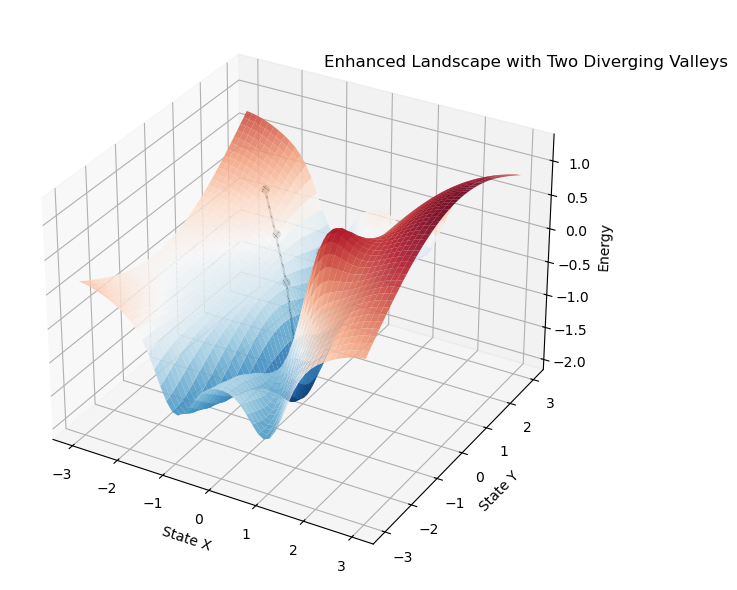

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def healthy_energy(x, y):
    """
    Enhanced energy landscape with two diverging valleys.
    The valleys are centered at x = ± y/3 so that they split as y increases.
    """
    # Base energy as before
    base = 0.8 * np.sin(0.5*x) * np.cos(0.5*y) - 0.5 * np.cos(x) + 0.1 * y
    # Two diverging valleys: one shifting to negative x and the other to positive x as |y| increases.
    valley1 = -0.8 * np.exp(-(((x + y/3) / 0.5)**2))
    valley2 = -0.8 * np.exp(-(((x - y/3) / 0.5)**2))
    # Extra bump: a Gaussian bump centered at (1, -1)
    bump = 1 * np.exp(-(((x-1)**2 + (y+1)**2) / 0.5))
    return base + valley1 + valley2 + bump

def main():
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Define the ranges for X and Y
    x_min, x_max = -3, 3
    y_min, y_max = -3, 3
    resolution = 50

    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x, y)

    # Plot the enhanced surface with two diverging valleys
    Z_hlt = healthy_energy(X, Y)
    surf_hlt = ax.plot_surface(X, Y, Z_hlt, 
                               cmap='RdBu_r', 
                               linewidth=0, 
                               antialiased=True,
                               alpha=0.9)

    # Illustrative trajectory on the enhanced landscape
    traj_x = np.linspace(-2, 2, 8)
    traj_y = np.linspace(2, -2, 8)
    traj_z = healthy_energy(traj_x, traj_y)
    ax.plot(traj_x, traj_y, traj_z, 
            color='black', linestyle='-', marker='o', markersize=5)

    ax.text2D(0.55, 0.9, "Enhanced Landscape with Two Diverging Valleys", transform=ax.transAxes, fontsize=12)
    ax.set_xlabel("State X")
    ax.set_ylabel("State Y")
    ax.set_zlabel("Energy")
    ax.view_init(elev=30, azim=-60)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


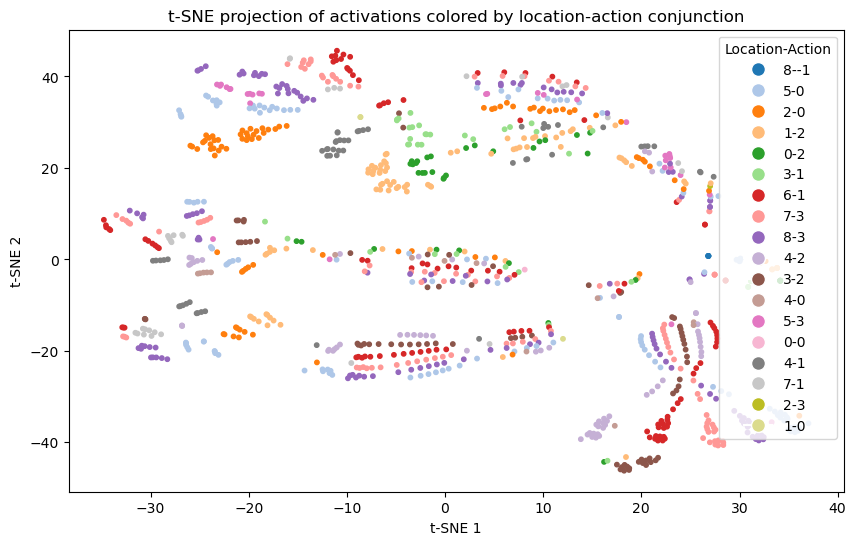

In [22]:
# Create a combined column for location and past action
combined_df['location_action'] = combined_df['location'].astype(str) + '-' + combined_df['past_action'].astype(str)

# Generate a unique color for each location-action combination
unique_combinations = combined_df['location_action'].unique()
combination_colors = {comb: plt.cm.tab20(i % 20) for i, comb in enumerate(unique_combinations)}

# Map the combined column to colors
colors = combined_df['location_action'].map(combination_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=combination_colors[comb], markersize=10) for comb in unique_combinations]
plt.legend(handles, unique_combinations, title='Location-Action')

plt.title('t-SNE projection of activations colored by location-action conjunction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()
